In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from utility import cart_to_sphe, sphe_to_cart, calculate_inter_angle_to_camera, get_sensor_filter, refractive_index_ice
from utility import calc_refracted_dir
import itertools

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['font.size'] = 15

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
src_dir = "../dats/"
diff = [20, 0, 0]
file_name = "ppc_log_x_%.2f_y_%.2f_z_%.2f_0.dat" % (diff[0], diff[1], diff[2])
dom_radius = 0.16510
camera_pos_sphe = np.array([0, np.pi/2])
camera_normal_vec = sphe_to_cart(camera_pos_sphe)
camera_pos_rad = dom_radius - 0.02 # Assume 5 cm apart from DOM boundary
camera_lens_rad = 0.005 * 10
opening_angle = np.pi * 2 / 3 # = 22.86 when the camera opening angle is 120 degree(Using sin's law)
scattering_length = 42.53 #[m]
absorption_length = 147.811 #[m]

In [3]:
data = np.fromfile(src_dir + file_name, dtype='<f4')
photon_log = data.reshape(-1, 8)
momentum= photon_log[:,5:3:-1]
direction = photon_log[:,7:5:-1]

## Draw raw arrival momentum 

Text(0.5,1,'Momentum of the photon interval]')

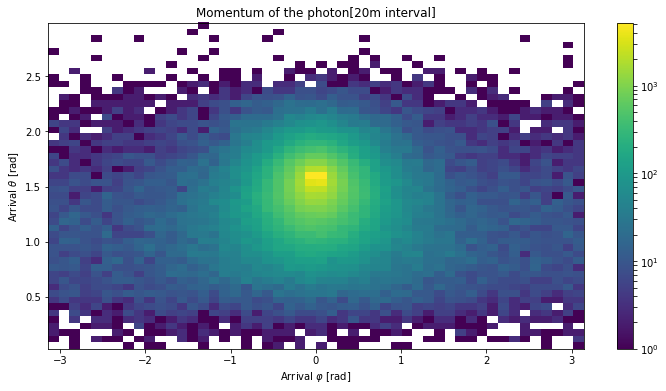

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
h = plt.hist2d(momentum[:,0], momentum[:,1], bins=50, norm=LogNorm());
plt.colorbar(h[3])
plt.xlabel("Arrival %s [rad]" % (r'$\varphi$'))
plt.ylabel("Arrival %s [rad]" % (r'$\theta$'))
plt.title('Momentum of the photon[20m interval]')

## Find the maximum range(opening angle)

In [5]:
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(-np.pi, np.pi, 100)
test_cases = np.array(list(itertools.product(phi, theta)))
test_angle = calculate_inter_angle_to_camera(camera_normal_vec, -sphe_to_cart(test_cases))

Text(0.5,1,'Possible momentum region under opening angle 120$\\degree$')

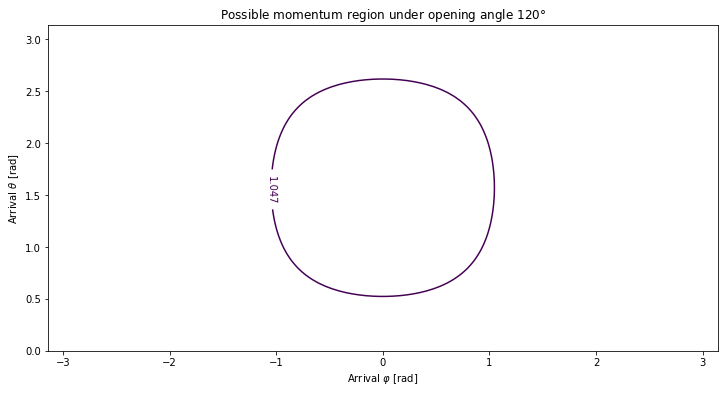

In [6]:
half_opening_angle = opening_angle / 2
fig, ax = plt.subplots(figsize=(12, 6))
CS = plt.contour(test_angle.reshape(100, 100).T, levels = [half_opening_angle], extent=[-np.pi, np.pi, 0, np.pi])
# CS = plt.contour(test_angle.reshape(100, 100), levels = [half_opening_angle])
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel("Arrival %s [rad]" % (r'$\varphi$'))
plt.ylabel("Arrival %s [rad]" % (r'$\theta$'))
plt.title('Possible momentum region under opening angle 120$\degree$')

## Check photon arrive in lens or not

In [7]:
sensor_filter = get_sensor_filter(direction, momentum, camera_pos_sphe, camera_lens_rad=camera_lens_rad, )

### Do the filtering
To get the filtered data on the sensor, we will apply the effective area

In [8]:
filtered_momentum = momentum[sensor_filter]

Text(0,0.5,'Arrival $\\theta$ [rad]')

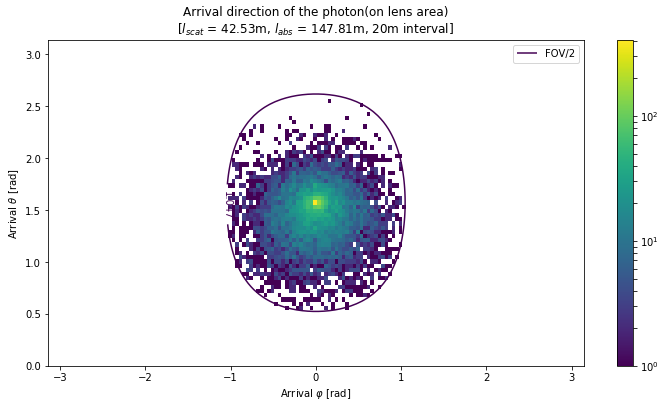

In [9]:
# mode == 1 : show total photon momentum, mode == 2 : apply filter
mode = 2

fig, ax = plt.subplots(figsize=(12, 6))
# CS = plt.contour(test_angle.reshape(100, 100), levels = [half_opening_angle], extent=[-np.pi, np.pi, 0, np.pi])
CS = plt.contour(test_angle.reshape(100, 100).T, levels = [half_opening_angle], extent=[-np.pi, np.pi, 0, np.pi])
CS.collections[0].set_label("FOV/2")

plt.clabel(CS, inline=1, fontsize=10)
if mode == 1:
    h = plt.hist2d(momentum[:,0], momentum[:,1], bins=50, norm=LogNorm());
    plt.title('Arrival direction of the photon\n[$l_{scat}$ = %.2fm, $l_{abs}$ = %.2fm, 20m interval]' 
          % (scattering_length, absorption_length))
else:
    h = plt.hist2d(filtered_momentum[:,0], filtered_momentum[:,1], bins=50, norm=LogNorm());
    plt.title('Arrival direction of the photon(on lens area)\n[$l_{scat}$ = %.2fm, $l_{abs}$ = %.2fm, 20m interval]' 
          % (scattering_length, absorption_length))

plt.colorbar(h[3])
plt.legend()
plt.xlim([-np.pi, np.pi])
plt.ylim([0, np.pi])
plt.xlabel("Arrival %s [rad]" % (r'$\varphi$'))
plt.ylabel("Arrival %s [rad]" % (r'$\theta$'))

# plt.title('Arrival direction of the photon(on lens area)\n[$l_{scat}$ = %.2fm, $l_{abs}$ = %.2fm, 20m interval]' 
#           % (scattering_length, absorption_length))

## Move from surface of pressure vessel to sensor
To get image information on the sensor, we need to considr the effect of pressure vessel because it makes refraction to the photon. So, we need to calculate refracted photon information using **Snell's law** and then filter the photon which can arrive in sensor. First, there are two refraction for the photon <br/>
1. Ice -> Pressure Veseel
2. Pressure vessel -> Interior of DOM<br/>

Naturally, it is important to calculate photon track inside of the vessel(between step 1 and 2). After calculation of two refraction, we can get photon information inside of the DOM(In this process, there are some photons which cannot pass the vessel due to refractive index). Then, we will check whether the photon track by these two steps<br/>
1. Whether the photon track will pass the camera lens area
2. Whether interior angle between photon momentum and lens normal vector is smaller than half of opening angle(FOV)<br/>

After finishing these all process, we can get photon information on the camera lens!

- Ref
- https://wiki.icecube.wisc.edu/index.php/Glass_Pressure_Vessel
- http://www.starkeffects.com/snells-law-vector.shtml

In [43]:
wv = 405 #[nm]

In [44]:
new_momentum, new_direction = pass_pressure_vessel(direction, momentum, refractive_index_ice(wv))

/home/jh/working_directory/cameraSim/cameraAnalysis/utility.py:137: RuntimeWarning: invalid value encountered in sqrt
  s2 = n * np.cross(N, -cross) - (N.T * np.sqrt(1 - n**2 * np.sum(cross * cross, axis=1))).T


In [45]:
refracted_filter = get_sensor_filter(new_direction, new_momentum, camera_pos_sphe, camera_lens_rad=camera_lens_rad, )

In [46]:
new_filtered_momentum = new_momentum[refracted_filter]

Text(0,0.5,'Arrival $\\theta$ [rad]')

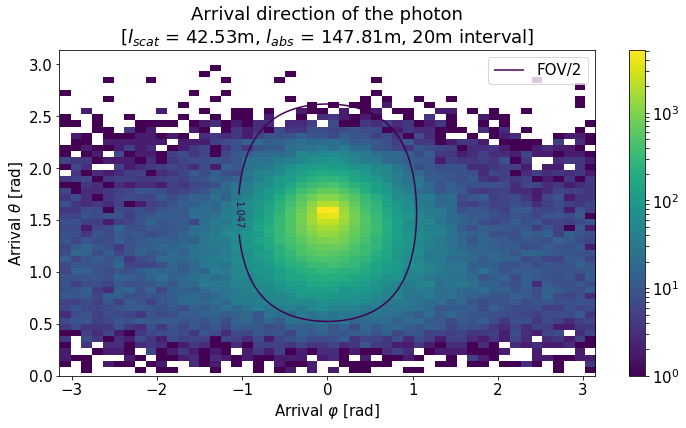

In [52]:
# mode == 1 : show total photon momentum, mode == 2 : apply filter
mode = 1

fig, ax = plt.subplots(figsize=(12, 6))
# CS = plt.contour(test_angle.reshape(100, 100), levels = [half_opening_angle], extent=[-np.pi, np.pi, 0, np.pi])
CS = plt.contour(test_angle.reshape(100, 100).T, levels = [half_opening_angle], extent=[-np.pi, np.pi, 0, np.pi])
CS.collections[0].set_label("FOV/2")

plt.clabel(CS, inline=1, fontsize=10)
if mode == 1:
    h = plt.hist2d(momentum[:,0], momentum[:,1], bins=50, norm=LogNorm());
    plt.title('Arrival direction of the photon\n[$l_{scat}$ = %.2fm, $l_{abs}$ = %.2fm, 20m interval]' 
          % (scattering_length, absorption_length))
else:
    h = plt.hist2d(new_filtered_momentum[:,0], new_filtered_momentum[:,1], bins=50, norm=LogNorm());
    plt.title('Arrival direction of the photon(on lens area)\n[$l_{scat}$ = %.2fm, $l_{abs}$ = %.2fm, 20m interval]' 
          % (scattering_length, absorption_length))

plt.colorbar(h[3])
plt.legend()
plt.xlim([-np.pi, np.pi])
plt.ylim([0, np.pi])
plt.xlabel("Arrival %s [rad]" % (r'$\varphi$'))
plt.ylabel("Arrival %s [rad]" % (r'$\theta$'))